In [1]:
#Not all these packages are required but they are here for completeness
import importlib
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu

In [2]:
# Import package 
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [51]:
import utils
importlib.reload(utils)
from utils import *

import slide
importlib.reload(slide)
from slide import *

In [4]:
# User Input parameters
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [5]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [6]:
SLIDE_NUM = 9
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 2171_T_11524A_4_


In [7]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [8]:
#Load Slides
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

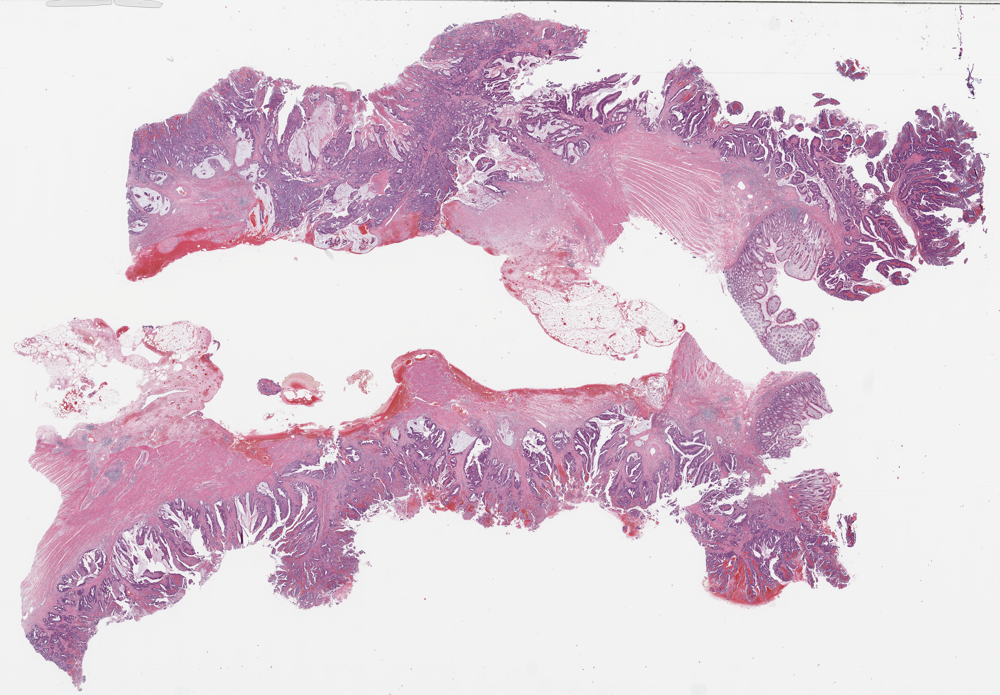

In [9]:
thumbnail(he)

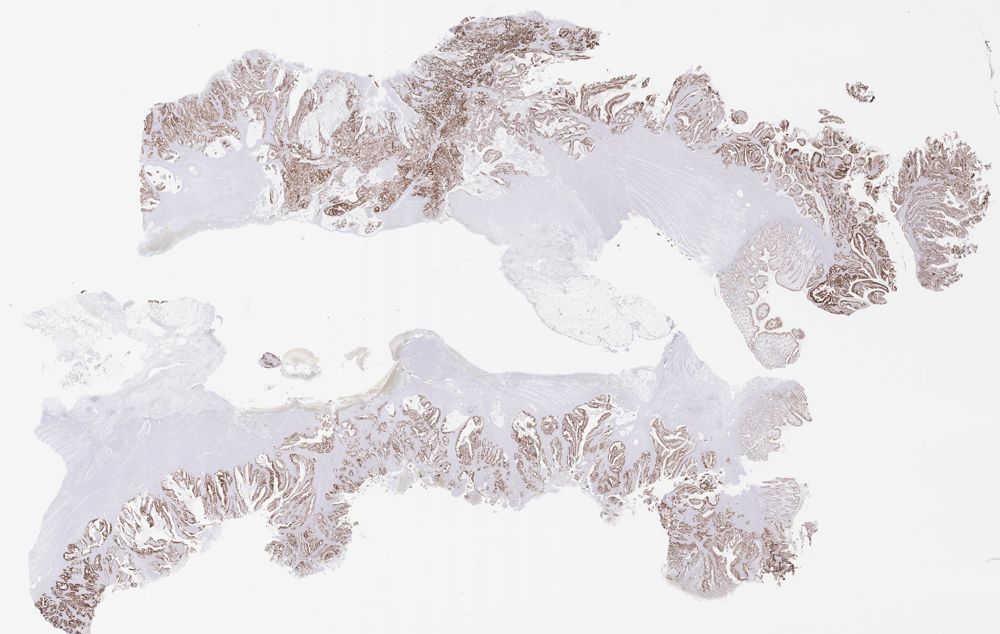

In [10]:
thumbnail(tp53)

### Image Registration

To enable labelling of H&E images from the TP53 images, these two images must be aligned to each other. Due to differences in sample preparation and imaging, these images are often not aligned so we need to register them to each other. 

In image registration, one image is set a fixed image and the other set as a moving image - it is the moving image that is tranformed to best align it to the fixed image. Here we set the H&E image as the fixed image and the TP53 Image as the moving image. We do this as the H&E image will later be used to train a convolutional neural network and we want the network to be able to use original patient H&E images. Thus, it is best that the images used to the train the network is in the same format as patient samples. 

In [11]:
######################
# Image Registration #
######################

INTERPOLATOR = sitk.sitkLanczosWindowedSinc

#Convert to grayscale
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)
#Set fixed and moving images
fixed_img = he_itk
moving_img = tp53_itk

# Check initial registration
# Centre the two images, then compare their alignment
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
moving_rgb = sitk_transform_rgb(tp53, he, initial_transform)
comparison_pre = show_alignment(he, moving_rgb, prefilter = True)
verbose_save_img(comparison_pre.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'comparison_pre_registration.jpeg'), 'JPEG' )

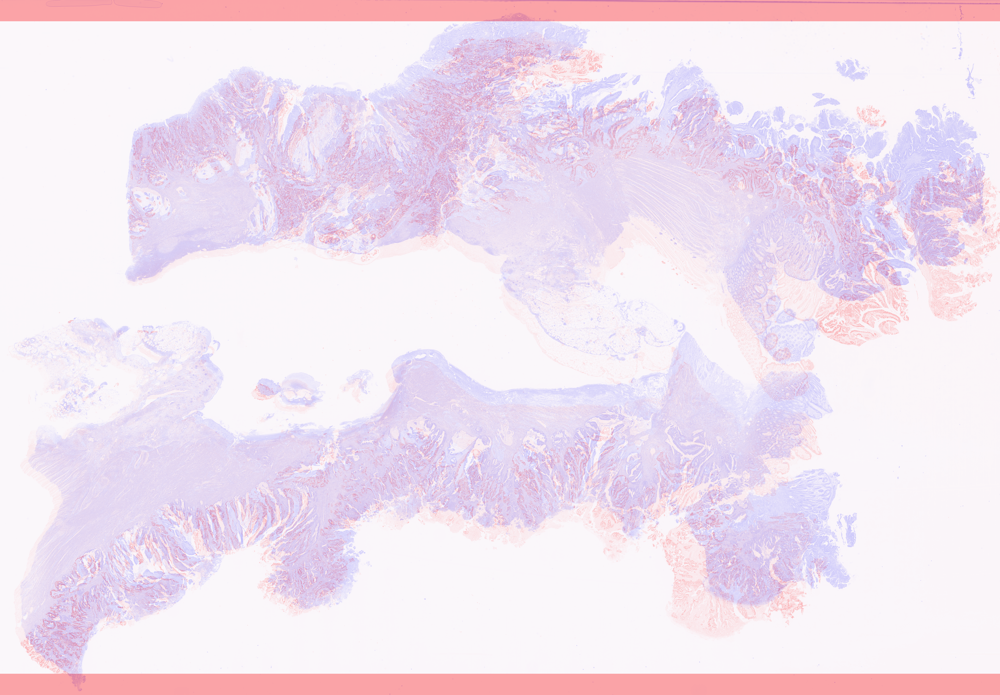

In [12]:
thumbnail(comparison_pre)

In [13]:
# Compute the mutual information between the original (unregistered) images
moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, 
                                 INTERPOLATOR, 0.0, moving_img.GetPixelID())
original_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled)))
verbose_print('Pre-registration mutual information metric: {0}'.format(original_mutual_info))

Pre-registration mutual information metric: 0.129295806634155


In [14]:
################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays 
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')
    
def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

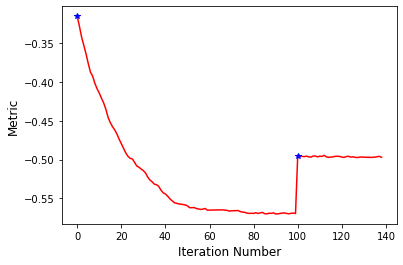

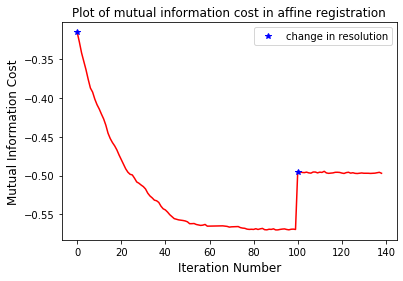

Affine metric value: -0.4954365781470571
Affine Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 39.


In [15]:
#Affine Registration
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(INTERPOLATOR)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: update_plot(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

affine_fig = plot_metric('Plot of mutual information cost in affine registration')
plt.show()
verbose_save_fig(affine_fig, OUTPUT_PATH.joinpath(PREFIX + 'affine_metric_plot.jpeg'))
end_plot()

verbose_print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
verbose_print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

In [16]:
#Compute the mutual information between the two images after affine registration
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 INTERPOLATOR, 0.0, moving_img.GetPixelID())
affine_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_affine)))
verbose_print('Affine mutual information metric: {0}'.format(affine_mutual_info))

Affine mutual information metric: 0.307415448840824


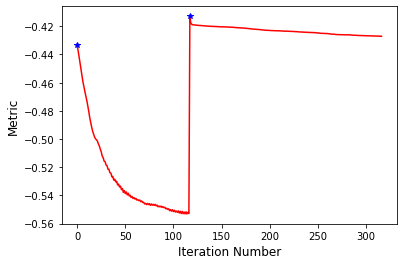

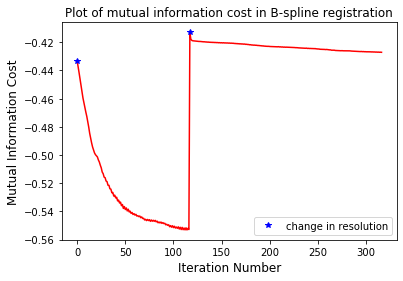

B-spline metric value: -0.42709048315187725
B-spline Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (200) exceeded.


In [17]:
#B-spline registration
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(INTERPOLATOR)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: update_plot(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

bspline_fig = plot_metric('Plot of mutual information cost in B-spline registration')
plt.show()
verbose_save_fig(bspline_fig, OUTPUT_PATH.joinpath(PREFIX + 'bspline_metric_plot.jpeg'))
end_plot()

verbose_print('B-spline metric value: {0}'.format(bspline_method.GetMetricValue()))
verbose_print('B-spline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [18]:
#Compute the mutual information between the two images after B-spline registration
moving_resampled_final = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 INTERPOLATOR, 0.0, moving_img.GetPixelID())
bspline_mutual_info = calculate_mutual_info(np.array(he_gray), np.array(get_pil_from_itk(moving_resampled_final)))
verbose_print('B-spline mutual information metric: {0}'.format(bspline_mutual_info))

B-spline mutual information metric: 0.38479491851622183


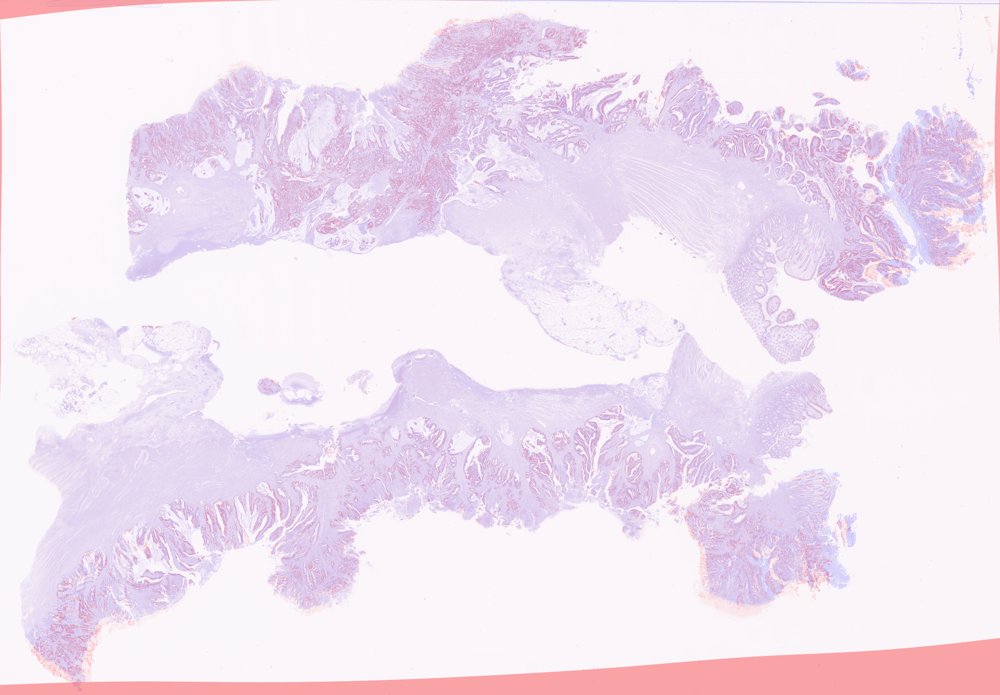

In [19]:
#Transform the original TP53 into the aligned TP53 image
moving_rgb_affine = sitk_transform_rgb(tp53, he, affine_transform, INTERPOLATOR)
tp53_aligned = sitk_transform_rgb(moving_rgb_affine, he, bspline_transform, INTERPOLATOR)
thumbnail(show_alignment(he, tp53_aligned, prefilter = True))

In [20]:
#Remove backgrounds from TP53 and H&E images
tp53_filtered = filter_green(tp53_aligned)
he_filtered = filter_green(he)
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he_filtered, tolerance = 15)

#Visually compare alignment between the registered TP53 and original H&E image
comparison_post = show_alignment(he_filtered, tp53_filtered)

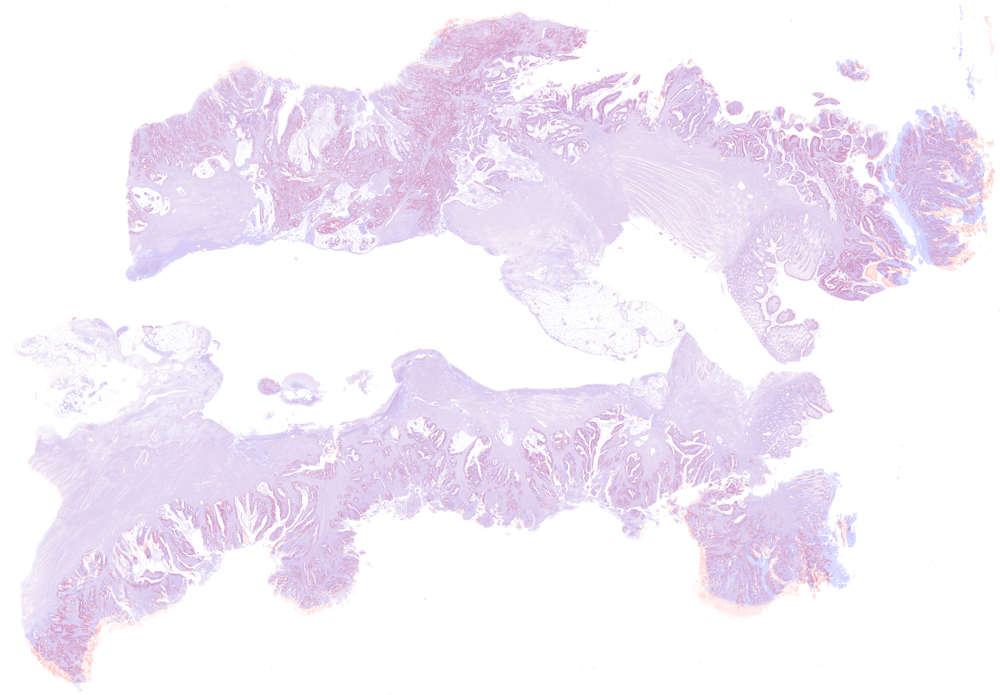

In [21]:
thumbnail(comparison_post)

In [22]:
verbose_save_img(comparison_post.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'comparison_post_registration.jpeg'), 'JPEG' )

### Tile Masks

In [23]:
####################################
# Generate cancer and tissue masks #
####################################

def cancer_mask(img, tile_size, cancer_thresh):
    #Determine Dab threshold with a smaller 1000x1000 image
    downsample = max(img.size)/1000
    img_small_size = tuple([np.int(np.round(dim/downsample)) for dim in img.size])
    img_small = img.resize(img_small_size, resample = Image.BICUBIC)
    hed_small = rgb2hed(img_small)
    dab_thresh = threshold_otsu_masked(hed_small)
    mask = []
    tgen = tile_gen(img, tile_size)
    shape = next(tgen)
    for tile in tgen:
        tile = tile.convert('RGB')
        tile_hed = rgb2hed(tile)
        tile_dab = -tile_hed[:,:,2]
        binary_dab = tile_dab > dab_thresh
        if np.array(binary2gray(binary_dab)).mean() < cancer_thresh:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)  

def show_mask(mask):
    return plt.imshow(np.reshape(mask, mask.shape[::-1]))

In [24]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [41]:
#Generate cancer mask and tissue mask from filtered tp53 image
c_mask = cancer_mask(tp53_filtered, tile_size, 250)
tgen = tile_gen(tp53_filtered, tile_size)
t_mask_tp53 = threshold_mask(tgen, 250)
tgen = tile_gen(he_filtered, tile_size)
t_mask_he = threshold_mask(tgen, 250)

#Generate tissue mask with tissue common to both the TP53 and H&E image
t_mask = np.logical_not(np.logical_not(t_mask_tp53) & np.logical_not(t_mask_he))
#Make sure all cancer tiles exist in the tissue mask
c_mask_filtered = np.logical_not(np.logical_not(c_mask) & np.logical_not(t_mask))

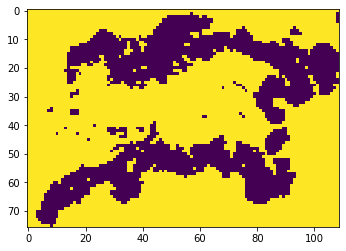

In [42]:
show_mask(c_mask)

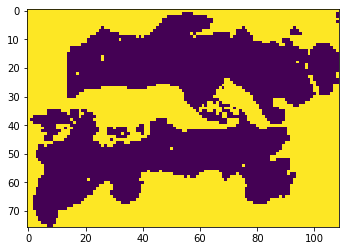

In [43]:
show_mask(t_mask_tp53)

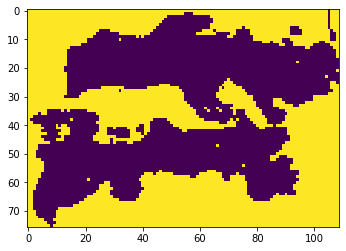

In [44]:
show_mask(t_mask_he)

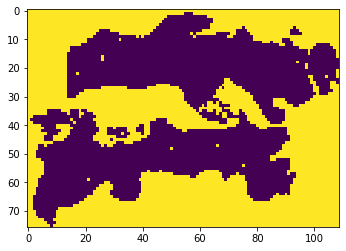

In [45]:
show_mask(t_mask)

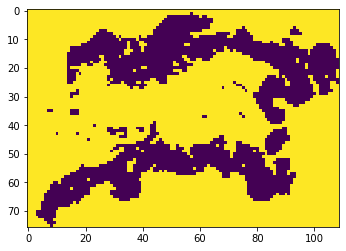

In [46]:

show_mask(c_mask_filtered)

In [47]:
def plot_masks(img, c_mask, t_mask, tile_size):
    img_overlay = img.copy()
    d = ImageDraw.Draw(img_overlay)
    tile_coords = tile_coordinates(img, tile_size)
    tile_coords['c_mask'] = c_mask.ravel()
    tile_coords['t_mask'] = t_mask.ravel()
    width = int(np.round(tile_size*0.03))
    for row in tile_coords.itertuples(index = False):
        x_top_left, y_top_left = np.round(row[2:4])
        x_bottom_right, y_bottom_right = np.ceil(row[4:6])
        if row[6] == 0:
            outline = 'red'
        elif row[7] == 0:
            outline = 'lime'
        else:
            outline = 'grey'
        d.rectangle([(x_top_left, y_top_left), (x_bottom_right, y_bottom_right)], outline = outline, width = width)
    return img_overlay

In [32]:
overlay_tp53 = plot_masks(tp53_filtered, c_mask_filtered, t_mask, tile_size)
verbose_save_img(overlay_tp53.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'TP53_overlay.jpeg'), 'JPEG' )

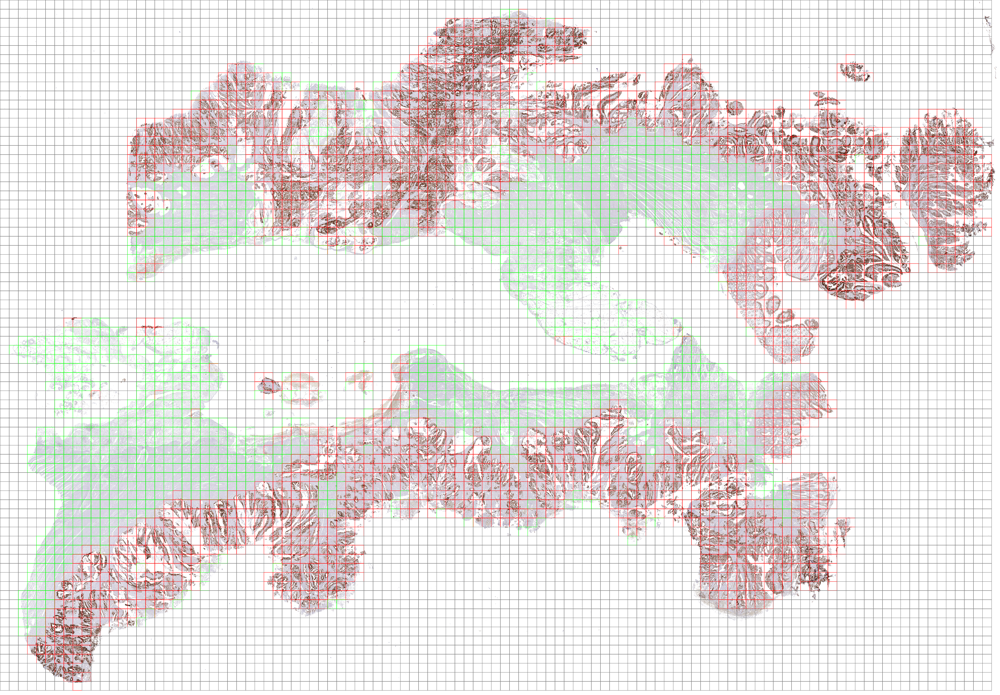

In [33]:
thumbnail(overlay_tp53)

In [48]:
overlay_he = plot_masks(he_filtered, c_mask_filtered, t_mask, tile_size)
verbose_save_img(overlay_he.convert('RGB'), OUTPUT_PATH.joinpath(PREFIX + 'HE_overlay.jpeg'), 'JPEG' )

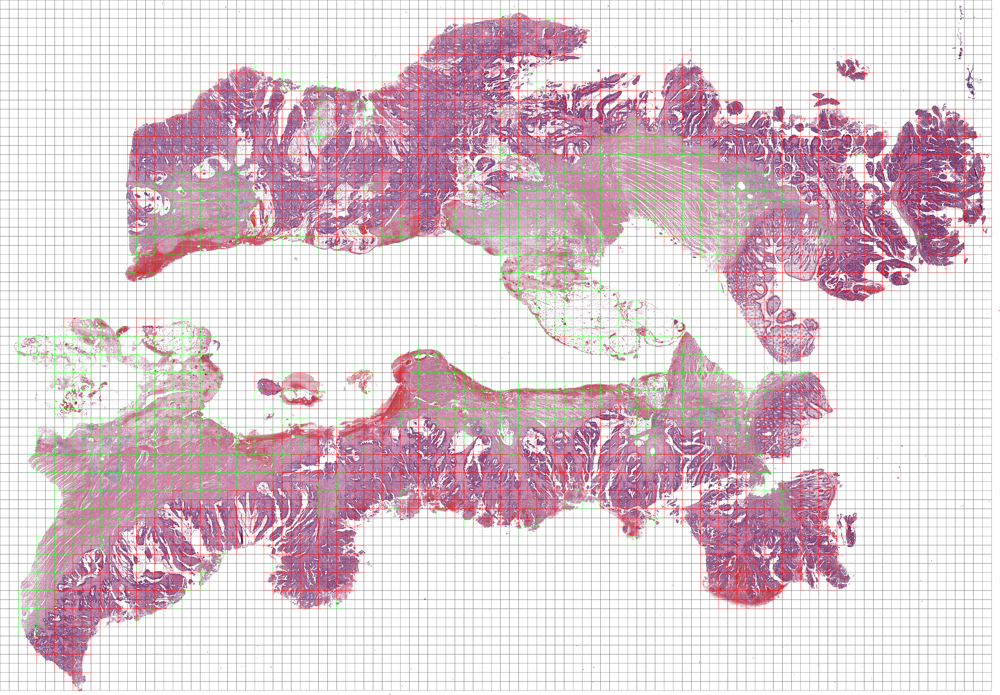

In [36]:
thumbnail(overlay_he)

In [38]:
##############
# Save Tiles #
##############

#Make Directory to save tiles
TILES_PATH = OUTPUT_PATH.joinpath('tiles_' + str(TILE_MAG) + 'x') 
os.makedirs(TILES_PATH, exist_ok = True )

In [49]:
def save_train_tiles(path, tile_gen, cancer_mask, tissue_mask, prefix = ''):
    os.makedirs(TILES_PATH.joinpath('cancer'), exist_ok = True)
    os.makedirs(TILES_PATH.joinpath('non-cancer'), exist_ok = True)
    x_tiles, y_tiles = next(tile_gen)
    verbose_print('Whole Image Size is {0} x {1}'.format(x_tiles, y_tiles))
    i = 0 
    for tile in tile_gen:
        img = tile.convert('RGB')
        #Name tile as horizontal position _ vertical position starting at (0,0)
        tile_name = prefix + str(np.floor_divide(i,x_tiles)) + '_' +  str(i%x_tiles) 
        if cancer_mask.ravel()[i] == 0:
            img.save(path.joinpath('cancer', tile_name + '.jpeg'), 'JPEG')
        elif tissue_mask.ravel()[i] == 0:
            img.save(path.joinpath('non-cancer', tile_name + '.jpeg'), 'JPEG')
        i += 1
    verbose_print('Exported tiles for {0}'.format(prefix))

In [52]:
tgen = tile_gen_at_mag(he_slide, TILE_MAG, 299)
save_train_tiles(TILES_PATH, tgen, c_mask_filtered, t_mask, prefix = PREFIX)

Whole Image Size is 109 x 76
Exported tiles for 2171_T_11524A_4_
